In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Processing

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 42.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import os
import random
import shutil
import pandas as pd

# Paths
data_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/data/Columbia Gaze Data Set'
train_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/train'
vali_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/vali'
test_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/test'

# Create directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(vali_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Define class labels for horizontal gaze, vertical gaze, and head pose angles
h_classes = {-15: 0, -10: 1, -5: 2, 0: 3, 5: 4, 10: 5, 15: 6}
v_classes = {-10: 0, 0: 1, 10: 2}
hp_classes = {-30: 0, -15: 1, 0: 2, 15: 3, 30: 4}

# Function to map angles to class labels
def angle_to_class(h, v, hp):
    h_class = h_classes.get(h, -1)
    v_class = v_classes.get(v, -1)
    hp_class = hp_classes.get(hp, -1)
    return h_class, v_class, hp_class

# Function to copy files to new directories
def copy_files(image_list, destination):
    for image_path in image_list:
        dest_path = os.path.join(destination, os.path.basename(image_path))
        shutil.copy(image_path, dest_path)

# Process each folder
train_data = []
vali_data = []
test_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        images = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        random.shuffle(images)

        train_images = images[:15]
        vali_images = images[15:20]
        test_images = images[20:25]

        for image_name in train_images:
            image_path = os.path.join(folder_path, image_name)
            parts = image_name.split('_')
            subject_id = parts[0]
            dis = int(parts[1].replace('m', ''))
            hp = int(parts[2].replace('P', '').replace('-', ''))
            v = int(parts[3].replace('V', '').replace('-', ''))
            h = int(parts[4].replace('H.jpg', '').replace('-', ''))
            h_class, v_class, hp_class = angle_to_class(h, v, hp)
            train_data.append([subject_id, dis, hp_class, h_class, v_class, image_path])

        for image_name in vali_images:
            image_path = os.path.join(folder_path, image_name)
            parts = image_name.split('_')
            subject_id = parts[0]
            dis = int(parts[1].replace('m', ''))
            hp = int(parts[2].replace('P', '').replace('-', ''))
            v = int(parts[3].replace('V', '').replace('-', ''))
            h = int(parts[4].replace('H.jpg', '').replace('-', ''))
            h_class, v_class, hp_class = angle_to_class(h, v, hp)
            vali_data.append([subject_id, dis, hp_class, h_class, v_class, image_path])

        for image_name in test_images:
            image_path = os.path.join(folder_path, image_name)
            parts = image_name.split('_')
            subject_id = parts[0]
            dis = int(parts[1].replace('m', ''))
            hp = int(parts[2].replace('P', '').replace('-', ''))
            v = int(parts[3].replace('V', '').replace('-', ''))
            h = int(parts[4].replace('H.jpg', '').replace('-', ''))
            h_class, v_class, hp_class = angle_to_class(h, v, hp)
            test_data.append([subject_id, dis, hp_class, h_class, v_class, image_path])

        copy_files([os.path.join(folder_path, img) for img in train_images], train_path)
        copy_files([os.path.join(folder_path, img) for img in vali_images], vali_path)
        copy_files([os.path.join(folder_path, img) for img in test_images], test_path)

# Convert to DataFrames
train_df = pd.DataFrame(train_data, columns=['subject_id', 'dis', 'hp_class', 'h_class', 'v_class', 'image_path'])
vali_df = pd.DataFrame(vali_data, columns=['subject_id', 'dis', 'hp_class', 'h_class', 'v_class', 'image_path'])
test_df = pd.DataFrame(test_data, columns=['subject_id', 'dis', 'hp_class', 'h_class', 'v_class', 'image_path'])

# Save as CSV files
train_df.to_csv(os.path.join('/content/drive/MyDrive/Columbia_Gaze_Data_Set', 'train_labels.csv'), index=False)
vali_df.to_csv(os.path.join('/content/drive/MyDrive/Columbia_Gaze_Data_Set', 'vali_labels.csv'), index=False)
test_df.to_csv(os.path.join('/content/drive/MyDrive/Columbia_Gaze_Data_Set', 'test_labels.csv'), index=False)

# Load Data

In [2]:
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Dataset class
class GazeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx]['image_path']

        if isinstance(img_path, np.int64):
            print(f"Image path: {img_path}, Type: {type(img_path)}")
            return None, None

        image = Image.open(img_path).convert('RGB')
        hp = self.data_frame.iloc[idx]['hp_class']
        gh = self.data_frame.iloc[idx]['h_class']
        gv = self.data_frame.iloc[idx]['v_class']
        labels = np.array([hp, gh, gv], dtype='float32')

        if self.transform:
            image = self.transform(image)

        return image, labels

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# File paths for CSV files
train_csv = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/train_labels.csv'
vali_csv = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/vali_labels.csv'
test_csv = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/test_labels.csv'

# Create datasets and dataloaders
train_dataset = GazeDataset(csv_file=train_csv, transform=transform)
vali_dataset = GazeDataset(csv_file=vali_csv, transform=transform)
test_dataset = GazeDataset(csv_file=test_csv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Fine-tuned

In [ ]:
def train_model(train_loader, vali_loader, model_name):

    model = models.resnet50(pretrained=True)

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 3)
    )

    for param in model.parameters():
        param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.fc.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    scaler = GradScaler()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    num_epochs = 50
    train_losses = []
    vali_losses = []

    print(f"Starting training for {model_name}")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (images, gazes) in enumerate(train_loader):
            images, gazes = images.to(device), gazes.to(device).float()
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, gazes)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)

            if i % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item()}")

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, {model_name} Training Loss: {train_loss:.4f}')

        model.eval()
        vali_loss = 0.0
        with torch.no_grad():
            for images, gazes in vali_loader:
                images, gazes = images.to(device), gazes.to(device)
                outputs = model(images)
                loss = criterion(outputs, gazes)
                vali_loss += loss.item() * images.size(0)

        vali_loss /= len(vali_loader.dataset)
        vali_losses.append(vali_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, {model_name} Validation Loss: {vali_loss:.4f}')

        scheduler.step()

    # Save the model
    model_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_combined.pth'
    torch.save(model.state_dict(), model_path)
    print(f"{model_name} model saved to {model_path}")

    train_losses_df = pd.DataFrame({'train_loss': train_losses})
    vali_losses_df = pd.DataFrame({'vali_loss': vali_losses})

    train_losses_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_combined_tl.csv'
    vali_losses_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_combined_vl.csv'

    train_losses_df.to_csv(train_losses_path, index=False)
    vali_losses_df.to_csv(vali_losses_path, index=False)

    print(f"{model_name} Training losses saved to {train_losses_path}")
    print(f"{model_name} Validation losses saved to {vali_losses_path}")

train_model(train_loader, vali_loader, "ft")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


Starting training for ft
Epoch 1/50, Batch 0/27, Loss: 12.469836235046387
Epoch 1/50, Batch 10/27, Loss: 2.6717441082000732
Epoch 1/50, Batch 20/27, Loss: 1.017289638519287
Epoch 1/50, ft Training Loss: 4.0635
Epoch 1/50, ft Validation Loss: 1.1438
Epoch 2/50, Batch 0/27, Loss: 1.2524604797363281
Epoch 2/50, Batch 10/27, Loss: 0.6888529658317566
Epoch 2/50, Batch 20/27, Loss: 0.8110653162002563
Epoch 2/50, ft Training Loss: 0.9570
Epoch 2/50, ft Validation Loss: 0.7592
Epoch 3/50, Batch 0/27, Loss: 0.9097983837127686
Epoch 3/50, Batch 10/27, Loss: 1.0004762411117554
Epoch 3/50, Batch 20/27, Loss: 0.6536149978637695
Epoch 3/50, ft Training Loss: 0.8454
Epoch 3/50, ft Validation Loss: 0.7290
Epoch 4/50, Batch 0/27, Loss: 0.6988526582717896
Epoch 4/50, Batch 10/27, Loss: 0.6890853643417358
Epoch 4/50, Batch 20/27, Loss: 0.8241852521896362
Epoch 4/50, ft Training Loss: 0.8115
Epoch 4/50, ft Validation Loss: 0.6957
Epoch 5/50, Batch 0/27, Loss: 0.8587716817855835
Epoch 5/50, Batch 10/27, Lo

# Proxy-tuning

In [4]:
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import torchvision.models as models
import torch.nn as nn
import pandas as pd

# Define large and small models
large_model = models.resnet50(pretrained=True)
large_model.fc = nn.Sequential(
    nn.Linear(large_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)

small_model = models.resnet18(pretrained=False)
small_model.fc = nn.Sequential(
    nn.Linear(small_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)

anti_expert_model = models.resnet18(pretrained=False)
anti_expert_model.fc = nn.Sequential(
    nn.Linear(anti_expert_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)

# Freeze the large model and anti-expert model
for param in large_model.parameters():
    param.requires_grad = False

for param in anti_expert_model.parameters():
    param.requires_grad = False

# Ensure the small model is trainable
for param in small_model.parameters():
    param.requires_grad = True

def proxy_tuning(train_loader, vali_loader, large_model, small_model, anti_expert_model, model_name):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(small_model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    scaler = GradScaler()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    large_model = large_model.to(device)
    small_model = small_model.to(device)
    anti_expert_model = anti_expert_model.to(device)

    num_epochs = 50
    train_losses = []
    vali_losses = []
    best_val_loss = float('inf')
    #early_stop_count = 0
    #early_stop_patience = 10

    print(f"Starting proxy tuning for {model_name}")
    for epoch in range(num_epochs):
        small_model.train()
        train_loss = 0.0
        for i, (images, gazes) in enumerate(train_loader):
            images, gazes = images.to(device), gazes.to(device).float()
            optimizer.zero_grad()

            with autocast():
                with torch.no_grad():
                    anti_expert_outputs = anti_expert_model(images)

                small_outputs = small_model(images)

                # The adjustment term
                adjustment_term = small_outputs - anti_expert_outputs

                # Combine primary loss and regularization term
                primary_loss = criterion(small_outputs, gazes)
                regularization_term = criterion(adjustment_term, gazes)
                loss = primary_loss + 0.1 * regularization_term

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)

            if i % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item()}")

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, {model_name} Training Loss: {train_loss:.4f}')

        small_model.eval()
        vali_loss = 0.0
        with torch.no_grad():
            for images, gazes in vali_loader:
                images, gazes = images.to(device), gazes.to(device)
                small_outputs = small_model(images)
                loss = criterion(small_outputs, gazes)
                vali_loss += loss.item() * images.size(0)

        vali_loss /= len(vali_loader.dataset)
        vali_losses.append(vali_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, {model_name} Validation Loss: {vali_loss:.4f}')

        scheduler.step(vali_loss)

    # Save the final model
    model_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_final.pth'
    torch.save(small_model.state_dict(), model_path)
    print(f"{model_name} model saved to {model_path}")

    train_losses_df = pd.DataFrame({'train_loss': train_losses})
    vali_losses_df = pd.DataFrame({'vali_loss': vali_losses})

    train_losses_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_pt_tl.csv'
    vali_losses_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_pt_vl.csv'

    train_losses_df.to_csv(train_losses_path, index=False)
    vali_losses_df.to_csv(vali_losses_path, index=False)

    print(f"{model_name} Training losses saved to {train_losses_path}")
    print(f"{model_name} Validation losses saved to {vali_losses_path}")

# Perform proxy tuning
proxy_tuning(train_loader, vali_loader, large_model, small_model, anti_expert_model, "pt")

Starting proxy tuning for pt
Epoch 1/50, Batch 0/27, Loss: 12.639366149902344
Epoch 1/50, Batch 10/27, Loss: 1.0062848329544067
Epoch 1/50, Batch 20/27, Loss: 0.7996443510055542
Epoch 1/50, pt Training Loss: 2.9470
Epoch 1/50, pt Validation Loss: 0.8248
Epoch 2/50, Batch 0/27, Loss: 1.1298716068267822
Epoch 2/50, Batch 10/27, Loss: 0.8111882209777832
Epoch 2/50, Batch 20/27, Loss: 0.7055222988128662
Epoch 2/50, pt Training Loss: 0.8131
Epoch 2/50, pt Validation Loss: 0.5551
Epoch 3/50, Batch 0/27, Loss: 0.7926198840141296
Epoch 3/50, Batch 10/27, Loss: 0.5270130634307861
Epoch 3/50, Batch 20/27, Loss: 0.7175177335739136
Epoch 3/50, pt Training Loss: 0.7348
Epoch 3/50, pt Validation Loss: 0.6220
Epoch 4/50, Batch 0/27, Loss: 0.6214504241943359
Epoch 4/50, Batch 10/27, Loss: 0.716810405254364
Epoch 4/50, Batch 20/27, Loss: 0.6616451144218445
Epoch 4/50, pt Training Loss: 0.7033
Epoch 4/50, pt Validation Loss: 0.4773
Epoch 5/50, Batch 0/27, Loss: 0.6901995539665222
Epoch 5/50, Batch 10/27

# Evaluation for both models

In [10]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import numpy as np

# Define the evaluation function
def evaluate_model(test_loader, model, criterion):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return test_loss, all_outputs, all_labels

# Load and evaluate the fine-tuned ResNet-50 model
def load_and_evaluate_ft_model(model_name, model_path, test_loader):
    # Initialize the ResNet-50 model
    model = models.resnet50(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 3)
    )

    # Load the model weights
    model.load_state_dict(torch.load(model_path))

    # Define the loss function
    criterion = nn.MSELoss()

    # Evaluate the model
    test_loss, test_outputs, test_labels = evaluate_model(test_loader, model, criterion)

    print(f'Test Loss: {test_loss:.4f}')

    # Save the predictions to a CSV file for further analysis
    test_results_df = pd.DataFrame({
        'pred_hp': test_outputs[:, 0],
        'pred_hg': test_outputs[:, 1],
        'pred_vg': test_outputs[:, 2],
        'true_hp': test_labels[:, 0],
        'true_hg': test_labels[:, 1],
        'true_vg': test_labels[:, 2]
    })

    test_results_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_test_results.csv'
    test_results_df.to_csv(test_results_path, index=False)
    print(f'Test results saved to {test_results_path}')

# Load and evaluate the proxy-tuned ResNet-18 model
def load_and_evaluate_pt_model(model_name, model_path, test_loader):
    # Initialize the ResNet-18 model
    model = models.resnet18(pretrained=False)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 3)
    )

    # Load the model weights
    model.load_state_dict(torch.load(model_path))

    # Define the loss function
    criterion = nn.MSELoss()

    # Evaluate the model
    test_loss, test_outputs, test_labels = evaluate_model(test_loader, model, criterion)

    print(f'Test Loss: {test_loss:.4f}')

    # Save the predictions to a CSV file for further analysis
    test_results_df = pd.DataFrame({
        'pred_hp': test_outputs[:, 0],
        'pred_hg': test_outputs[:, 1],
        'pred_vg': test_outputs[:, 2],
        'true_hp': test_labels[:, 0],
        'true_hg': test_labels[:, 1],
        'true_vg': test_labels[:, 2]
    })

    test_results_path = f'/content/drive/MyDrive/Columbia_Gaze_Data_Set/{model_name}_test_results.csv'
    test_results_df.to_csv(test_results_path, index=False)
    print(f'Test results saved to {test_results_path}')

# File paths for the saved models
ft_model_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_combined.pth'
pt_model_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_final.pth'

# Evaluate the fine-tuned model
print("Evaluating fine-tuned model:")
load_and_evaluate_ft_model("ft", ft_model_path, test_loader)

# Evaluate the proxy-tuned model
print("Evaluating proxy-tuned model:")
load_and_evaluate_pt_model("pt", pt_model_path, test_loader)

Evaluating fine-tuned model:
Test Loss: 0.5177
Test results saved to /content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_test_results.csv
Evaluating proxy-tuned model:
Test Loss: 0.5900
Test results saved to /content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_test_results.csv


In [12]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_rel
from torchvision import transforms, models
import torch.nn as nn

# Define the paths to the model checkpoints
ft_model_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_combined.pth'
proxy_model_path = '/content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_final.pth'

# Load the fine-tuned model
ft_model = models.resnet50(pretrained=False)
ft_model.fc = nn.Sequential(
    nn.Linear(ft_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)
ft_model.load_state_dict(torch.load(ft_model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
ft_model.eval()

# Load the proxy model
proxy_model = models.resnet18(pretrained=False)
proxy_model.fc = nn.Sequential(
    nn.Linear(proxy_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)
proxy_model.load_state_dict(torch.load(proxy_model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
proxy_model.eval()

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ft_model = ft_model.to(device)
proxy_model = proxy_model.to(device)

# Function to get predictions
def get_predictions(model, data_loader):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds.append(outputs.cpu().numpy())
            true_labels.append(labels.cpu().numpy())
    preds = np.concatenate(preds)
    true_labels = np.concatenate(true_labels)
    return preds, true_labels

# Get predictions from both models
ft_preds, true_labels = get_predictions(ft_model, test_loader)
proxy_preds, _ = get_predictions(proxy_model, test_loader)

# Extract true horizontal and vertical labels
true_horizontal = true_labels[:, 0]
true_vertical = true_labels[:, 1]

# Calculate MSE and MAE for both models
def calculate_errors(true_vals, preds):
    mse = mean_squared_error(true_vals, preds)
    mae = mean_absolute_error(true_vals, preds)
    return mse, mae

# Calculate errors
ft_mse_horizontal, ft_mae_horizontal = calculate_errors(true_horizontal, ft_preds[:, 0])
ft_mse_vertical, ft_mae_vertical = calculate_errors(true_vertical, ft_preds[:, 1])
proxy_mse_horizontal, proxy_mae_horizontal = calculate_errors(true_horizontal, proxy_preds[:, 0])
proxy_mse_vertical, proxy_mae_vertical = calculate_errors(true_vertical, proxy_preds[:, 1])

print(f'Fine-Tuning Model MSE (Horizontal): {ft_mse_horizontal:.4f}')
print(f'Fine-Tuning Model MAE (Horizontal): {ft_mae_horizontal:.4f}')
print(f'Fine-Tuning Model MSE (Vertical): {ft_mse_vertical:.4f}')
print(f'Fine-Tuning Model MAE (Vertical): {ft_mae_vertical:.4f}')

print(f'Proxy-Tuning Model MSE (Horizontal): {proxy_mse_horizontal:.4f}')
print(f'Proxy-Tuning Model MAE (Horizontal): {proxy_mae_horizontal:.4f}')
print(f'Proxy-Tuning Model MSE (Vertical): {proxy_mse_vertical:.4f}')
print(f'Proxy-Tuning Model MAE (Vertical): {proxy_mae_vertical:.4f}')

# Conduct paired t-test on errors
t_stat_mse_horizontal, p_value_mse_horizontal = ttest_rel(ft_preds[:, 0], proxy_preds[:, 0])
t_stat_mse_vertical, p_value_mse_vertical = ttest_rel(ft_preds[:, 1], proxy_preds[:, 1])
t_stat_mae_horizontal, p_value_mae_horizontal = ttest_rel(ft_preds[:, 0], proxy_preds[:, 0])
t_stat_mae_vertical, p_value_mae_vertical = ttest_rel(ft_preds[:, 1], proxy_preds[:, 1])

print(f'T-test MSE (Horizontal): t-statistic = {t_stat_mse_horizontal:.4f}, p-value = {p_value_mse_horizontal:.4f}')
print(f'T-test MSE (Vertical): t-statistic = {t_stat_mse_vertical:.4f}, p-value = {p_value_mse_vertical:.4f}')
print(f'T-test MAE (Horizontal): t-statistic = {t_stat_mae_horizontal:.4f}, p-value = {p_value_mae_horizontal:.4f}')
print(f'T-test MAE (Vertical): t-statistic = {t_stat_mae_vertical:.4f}, p-value = {p_value_mae_vertical:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-Tuning Model MSE (Horizontal): 0.1984
Fine-Tuning Model MAE (Horizontal): 0.3739
Fine-Tuning Model MSE (Vertical): 1.1400
Fine-Tuning Model MAE (Vertical): 0.9058
Proxy-Tuning Model MSE (Horizontal): 0.0326
Proxy-Tuning Model MAE (Horizontal): 0.1402
Proxy-Tuning Model MSE (Vertical): 1.5181
Proxy-Tuning Model MAE (Vertical): 1.0333
T-test MSE (Horizontal): t-statistic = -1.9978, p-value = 0.0467
T-test MSE (Vertical): t-statistic = 1.2356, p-value = 0.2176
T-test MAE (Horizontal): t-statistic = -1.9978, p-value = 0.0467
T-test MAE (Vertical): t-statistic = 1.2356, p-value = 0.2176


# Visualization

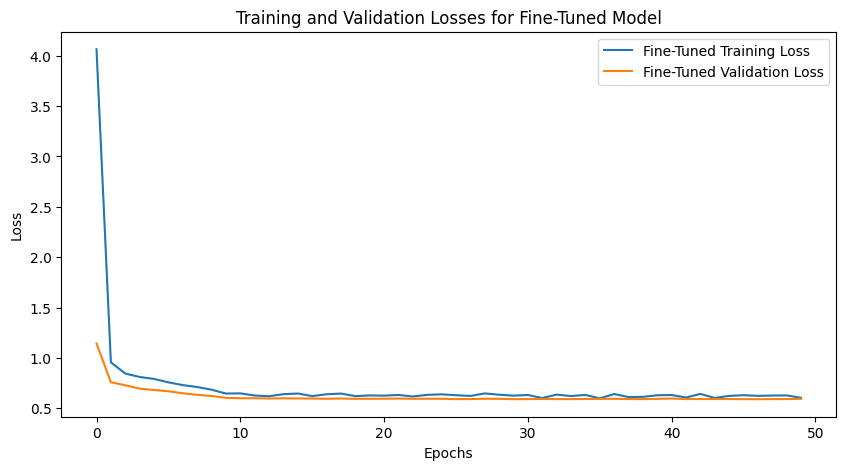

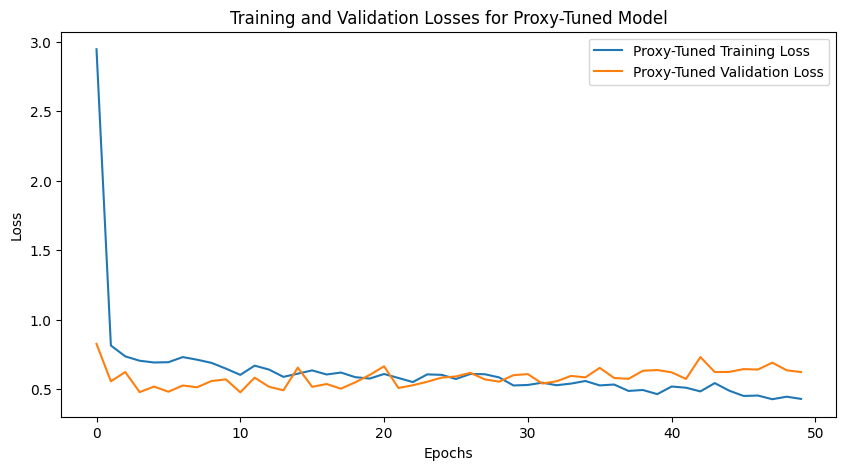

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the losses from CSV files
ft_train_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_combined_tl.csv')
ft_vali_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_combined_vl.csv')

pt_train_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_pt_tl.csv')
pt_vali_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_pt_vl.csv')

# Plot the training and validation losses for the fine-tuned model
plt.figure(figsize=(10, 5))
plt.plot(ft_train_losses['train_loss'], label='Fine-Tuned Training Loss')
plt.plot(ft_vali_losses['vali_loss'], label='Fine-Tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Fine-Tuned Model')
plt.legend()
plt.show()

# Plot the training and validation losses for the proxy-tuned model
plt.figure(figsize=(10, 5))
plt.plot(pt_train_losses['train_loss'], label='Proxy-Tuned Training Loss')
plt.plot(pt_vali_losses['vali_loss'], label='Proxy-Tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Proxy-Tuned Model')
plt.legend()
plt.show()

In [17]:
ft_test_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_test_results.csv')
pt_test_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_test_results.csv')

# Print the columns of each DataFrame
print("Fine-Tuned Test Losses Columns:", ft_test_losses.columns)
print("Proxy-Tuned Test Losses Columns:", pt_test_losses.columns)

Fine-Tuned Test Losses Columns: Index(['pred_hp', 'pred_hg', 'pred_vg', 'true_hp', 'true_hg', 'true_vg'], dtype='object')
Proxy-Tuned Test Losses Columns: Index(['pred_hp', 'pred_hg', 'pred_vg', 'true_hp', 'true_hg', 'true_vg'], dtype='object')


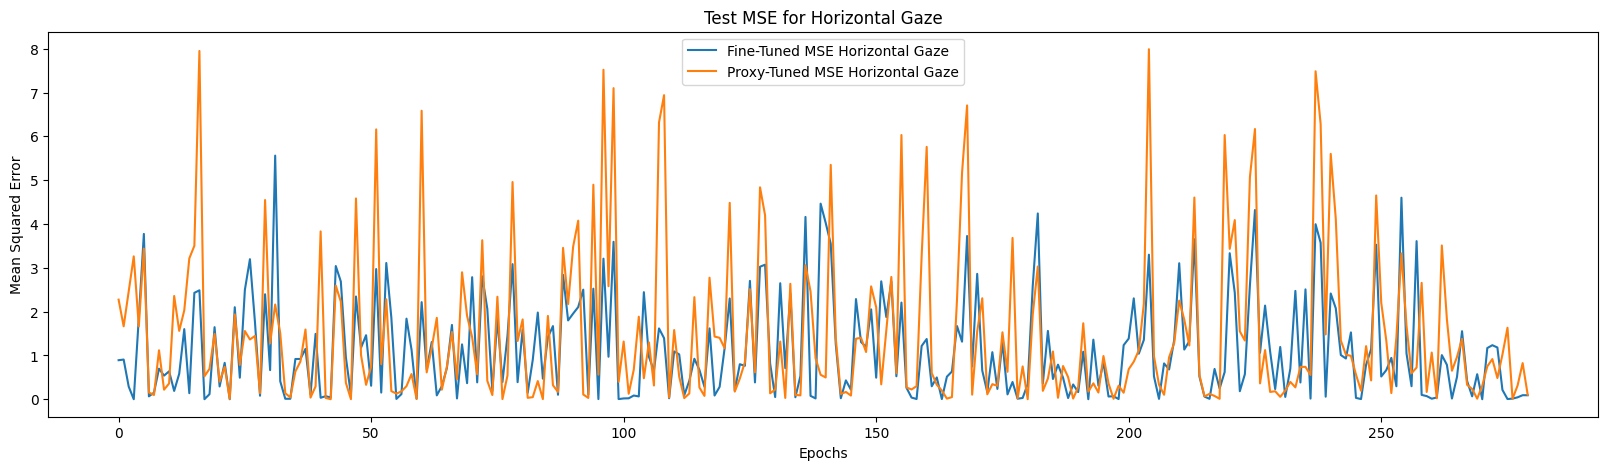

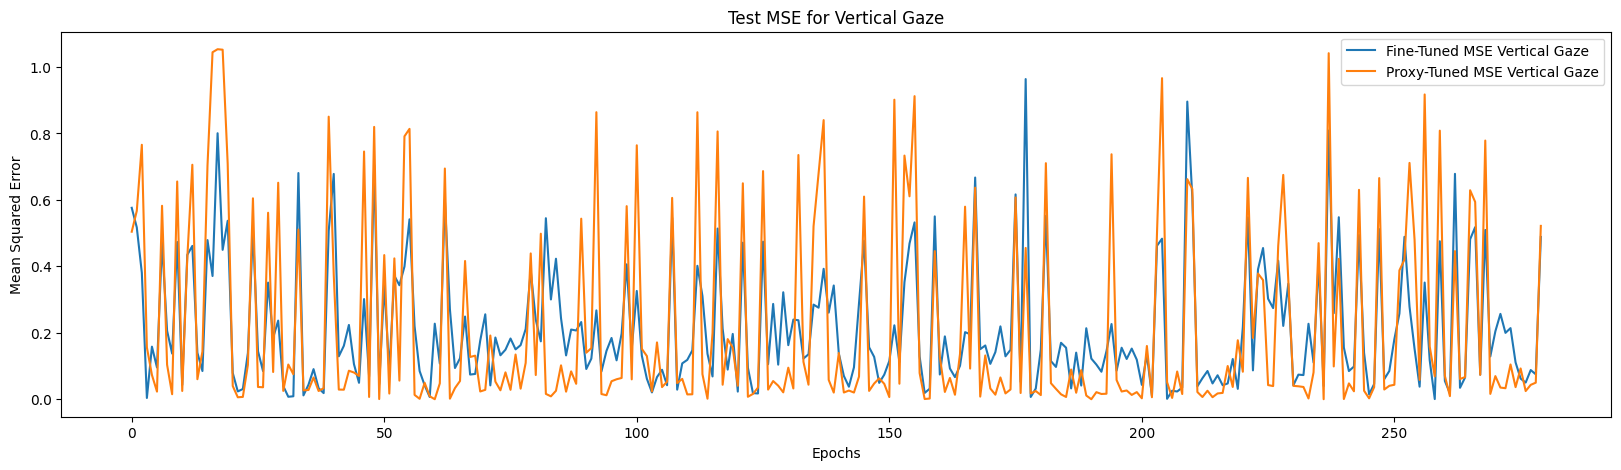

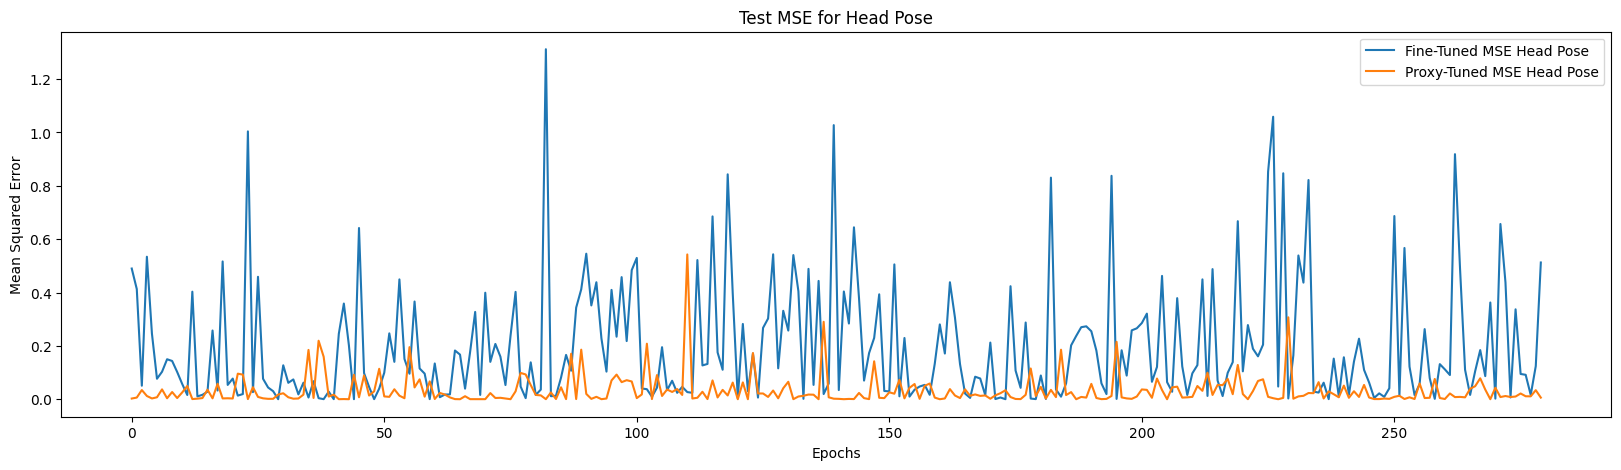

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the test losses from CSV files
ft_test_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_test_results.csv')
pt_test_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_test_results.csv')

# Calculate MSE for horizontal gaze, vertical gaze, and head pose
ft_test_losses['mse_hg'] = (ft_test_losses['pred_hg'] - ft_test_losses['true_hg']) ** 2
ft_test_losses['mse_vg'] = (ft_test_losses['pred_vg'] - ft_test_losses['true_vg']) ** 2
ft_test_losses['mse_hp'] = (ft_test_losses['pred_hp'] - ft_test_losses['true_hp']) ** 2

pt_test_losses['mse_hg'] = (pt_test_losses['pred_hg'] - pt_test_losses['true_hg']) ** 2
pt_test_losses['mse_vg'] = (pt_test_losses['pred_vg'] - pt_test_losses['true_vg']) ** 2
pt_test_losses['mse_hp'] = (pt_test_losses['pred_hp'] - pt_test_losses['true_hp']) ** 2

# Plot MSE for horizontal gaze
plt.figure(figsize=(20, 5))
plt.plot(ft_test_losses['mse_hg'], label='Fine-Tuned MSE Horizontal Gaze')
plt.plot(pt_test_losses['mse_hg'], label='Proxy-Tuned MSE Horizontal Gaze')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Test MSE for Horizontal Gaze')
plt.legend()
plt.show()

# Plot MSE for vertical gaze
plt.figure(figsize=(20, 5))
plt.plot(ft_test_losses['mse_vg'], label='Fine-Tuned MSE Vertical Gaze')
plt.plot(pt_test_losses['mse_vg'], label='Proxy-Tuned MSE Vertical Gaze')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Test MSE for Vertical Gaze')
plt.legend()
plt.show()

# Plot MSE for head pose
plt.figure(figsize=(20, 5))
plt.plot(ft_test_losses['mse_hp'], label='Fine-Tuned MSE Head Pose')
plt.plot(pt_test_losses['mse_hp'], label='Proxy-Tuned MSE Head Pose')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Test MSE for Head Pose')
plt.legend()
plt.show()

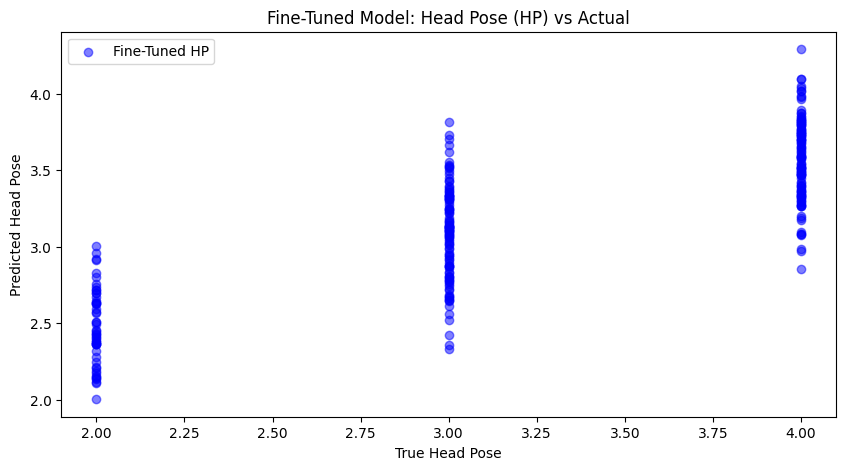

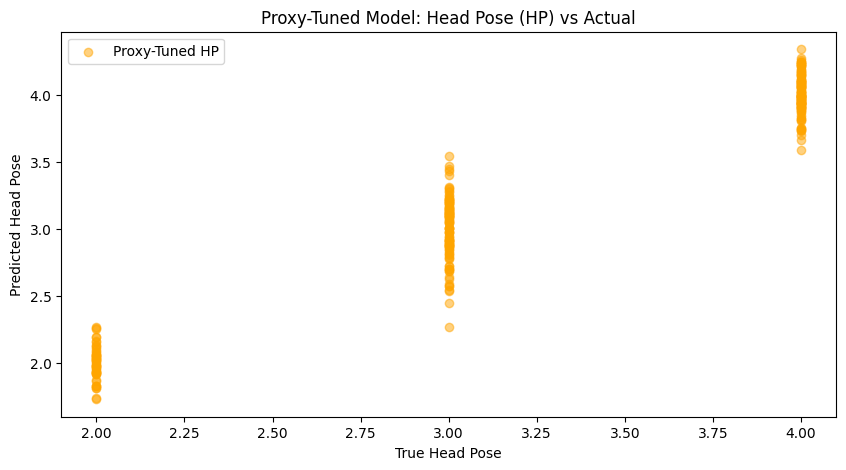

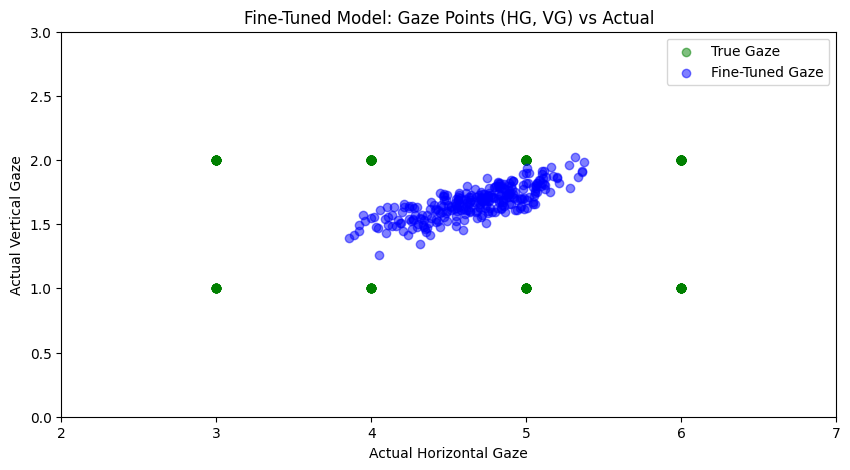

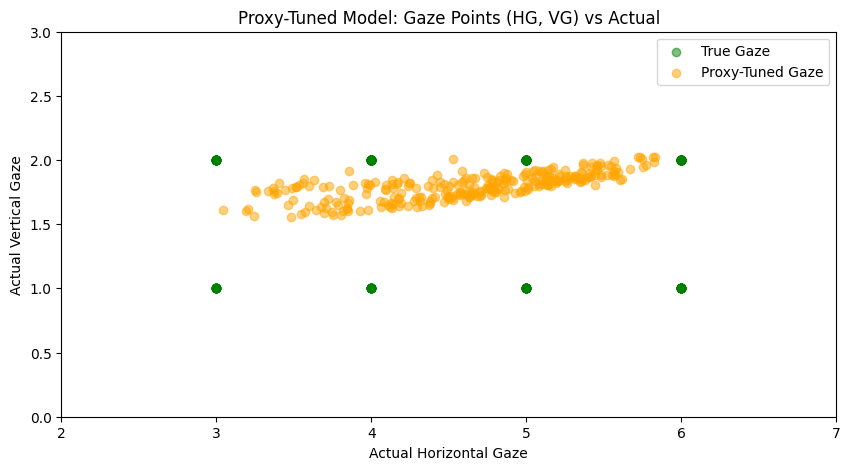

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the test losses from CSV files
ft_test_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_test_results.csv')
pt_test_losses = pd.read_csv('/content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_test_results.csv')

# Scatter plot for Head Pose (HP) - Fine-Tuned vs. Actual
plt.figure(figsize=(10, 5))
plt.scatter(ft_test_losses['true_hp'], ft_test_losses['pred_hp'], alpha=0.5, label='Fine-Tuned HP', color='blue')
plt.xlabel('True Head Pose')
plt.ylabel('Predicted Head Pose')
plt.title('Fine-Tuned Model: Head Pose (HP) vs Actual')
plt.legend()
plt.show()

# Scatter plot for Head Pose (HP) - Proxy-Tuned vs. Actual
plt.figure(figsize=(10, 5))
plt.scatter(pt_test_losses['true_hp'], pt_test_losses['pred_hp'], alpha=0.5, label='Proxy-Tuned HP', color='orange')
plt.xlabel('True Head Pose')
plt.ylabel('Predicted Head Pose')
plt.title('Proxy-Tuned Model: Head Pose (HP) vs Actual')
plt.legend()
plt.show()

# Scatter plot for Gaze Points (HG, VG) - Fine-Tuned vs. Actual
plt.figure(figsize=(10, 5))
plt.scatter(ft_test_losses['true_hg'], ft_test_losses['true_vg'], alpha=0.5, label='True Gaze', color='green')
plt.scatter(ft_test_losses['pred_hg'], ft_test_losses['pred_vg'], alpha=0.5, label='Fine-Tuned Gaze', color='blue')
plt.xlabel('Actual Horizontal Gaze')
plt.ylabel('Actual Vertical Gaze')
plt.title('Fine-Tuned Model: Gaze Points (HG, VG) vs Actual')
plt.legend()
plt.xlim(2, 7)
plt.ylim(0, 3)
plt.show()

# Scatter plot for Gaze Points (HG, VG) - Proxy-Tuned vs. Actual
plt.figure(figsize=(10, 5))
plt.scatter(pt_test_losses['true_hg'], pt_test_losses['true_vg'], alpha=0.5, label='True Gaze', color='green')
plt.scatter(pt_test_losses['pred_hg'], pt_test_losses['pred_vg'], alpha=0.5, label='Proxy-Tuned Gaze', color='orange')
plt.xlabel('Actual Horizontal Gaze')
plt.ylabel('Actual Vertical Gaze')
plt.title('Proxy-Tuned Model: Gaze Points (HG, VG) vs Actual')
plt.legend()
plt.xlim(2, 7)
plt.ylim(0, 3)
plt.show()

In [39]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install Git (if not already installed)
!apt-get install git

# Step 3: Configure Git with your username and email
!git config --global user.name "GChenCeph"
!git config --global user.email "guangkai@vt.edu"

# Step 4: Clone your GitHub repository
!git clone https://github.com/GChenCeph/eye_tracking.git
%cd eye_tracking

# Step 5: Copy the files from Google Drive to the cloned repository directory
!cp /content/drive/MyDrive/Colab\ Notebooks/gaze_tracking.ipynb .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/train_labels.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/vali_labels.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/test_labels.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_combined.pth .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_combined_tl.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_combined_vl.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_best.pth .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_pt_vl.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_final.pth .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_pt_tl.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/ft_test_results.csv .
!cp /content/drive/MyDrive/Columbia_Gaze_Data_Set/pt_test_results.csv .

# Step 6: Add, commit, and push the changes to your GitHub repository
!git add .
!git commit -m "Add files for gaze tracking project"

# Use a personal access token for authentication
import getpass
token = getpass.getpass("Enter your GitHub personal access token: ")
!git remote set-url origin https://{token}@github.com/GChenCeph/eye_tracking.git
!git push origin main

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'eye_tracking'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 722.01 KiB | 2.30 MiB/s, done.
/content/drive/My Drive/Columbia_Gaze_Data_Set/eye_tracking/eye_tracking/eye_tracking/eye_tracking/eye_tracking/eye_tracking
[main 9433d17] Add files for gaze tracking project
 13 files changed, 2170 insertions(+)
 create mode 100644 ft_combined.pth
 create mode 100644 ft_combined_tl.csv
 create mode 100644 ft_combined_vl.csv
 create mode 100644 ft_test_results.csv
 